# Deep Learning and Neural Networks Second Assignment 2024
### Ferenc Huszár and Nic Lane
#### due date: Friday, 21 March 2025, 12:00 PM

Welcome to the second assignment for the Deep Neural Networks module. In this assignment you will explore some of the model architectures we talked about in the second half of lectures (ConvNets, Transformers) and you will also implement a fun model called MLP Mixer.

There are 70 marks given in total for this second assessment ($70\%$ of the total of 100 marks for the course), broken into three sections:
* (D) 10 marks for the ConvNet exercise
* (E) 20 marks for the Transformer/MLP Mixer exercise
* (F) 40 marks for a mini-project of your choice

#### Compute Resources: Kaggle Notebooks

Since this Assignment benefits from GPU acceleration, we recommend using the [kaggle notebook](https://www.kaggle.com/docs/notebooks) platform. Kaggle notebooks are similar to google colab, but offer a more predictable 30 hours/week quota on their GPUs for free. This is plenty of GPU time to get the assignment done, you shouldn't need any more.

However, use your GPU quota sparingly, for example switch to a non-GPU instance unless you are working on tasks that need a GPU, and terminate your session once you're not working on it. To enable GPUs and Internet access, you need to verify your phone number on your kaggle account. This can be selected in the Notebook options section of the panel to the right of the actual notebook. Please talk to us if any issues arise.

#### Mini-projects

Mini-project tasks are a more exploratory and open-ended, giving you an opportunity to decide which aspect you'd like to focus on. The idea is to introduce you to the form of assess\ment typical in our Part III/MPhil modules. Mini-projects come with instructions, to indicate the depth of work we expect for certain marks, but you should feel free to deviate from instructions if you have a better idea to explore within the context. There are two options, one with a more theory/maths focus, one with more of an engineering focus.

As a guide, when marking we will take into account three factors:

* **extent of work:** did you do the expected amount of work (you won't get extra marks by doing a lot more than others, this is not a race). We will try to give an indication of this in the module description.
* **correctness/technical understanding:** is your solution and description of findings technincally correct, does it demonstrate learning and understanding of the topics we cover, and an ability to do independent reading if needed?
* **presentation:** How is the mini-project written up? Please focus on the writeup being short, to the point, well structured. Are figures well formatted, so it's clear what's shown on them (e.g. are there axis labels)?

You can choose whichever project you want to attempt. You can attempt more than one, but we will only mark one. **Please clearly state which of the mini-projects you would like us to mark**, if this is unclear, we will mark whichever appears fist in your submitted notebook.

# D: Feature Visualisation in ResNets

_[10 marks] 1 page writeup + appendices_

Although vision transformers have taken over in the large data setting, convolutional networks remain popular due to their parameter-efficiency and superior performance on smaller data.

In this question, we ask you to explore the features that a [ResNet 18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) model (considered tiny by today's standards) learns when trained on the popular ImageNet dataset. To do this, you will follow a procedure similar to this beautifully illustrated article: [Feature visualization with Optimization](https://distill.pub/2017/feature-visualization/#optimization).

# D.1: Feature Visualisation via Optimisation

Convnets learn to classify an image by transforming it into a series of feature maps, usually decreasing in spatial resolution (pyramidal structure) while increasing in width (number of channels). While the first layer's convolution kernels are interpretable, deeper featuremaps are less so, since these featuremaps integrate information through several different computational paths and from a larger area of an image. In this work you will generate visual "explanations" of various featuremaps in the form of input images for which the targeted feature values are highly active. Follow the method described in [the article](https://www.google.com/url?q=https%3A%2F%2Fdistill.pub%2F2017%2Ffeature-visualization%2F%23optimization).

Starting from a grey image (e.g. `0.5*torch.ones(...)`), use gradient-based optimization of the input image to find images such that on these resulting images, certain internal activations in the network take maximal (or at least very high) values. At first, use no additional regularisation (that's the next part). Create optimal images that maximise:
* a single activation in the middle (horizontally and vertically) of a chosen feature map/channel.
* a row of activations along a horizontal line in the feature map, in a single channel
* the sum of all activations of a single feature map (channel) across the whole image.
* the sum of all activations across all channels and spatial locations in `layer3`

*Tips:*
* When optimizing the activation in the middle of the image, expect to see a localised pattern that's most intense in the middle.
* Don't forget to apply the correct normalisation to the image before feeding it to the network. The correct normalization to use is included [in the documentation](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).
* Make sure the network is in evaluation mode, and that its parameters are not changed by your optimisation procedure.
* You may want to use the [`torch.no_grad()`](https://pytorch.org/docs/stable/generated/torch.no_grad.html) environment when applying operations which you don't want to end up becoming part of the computational graph.
* This will be much faster if you switch to a GPU backend. Make sure that all tensors (input, model, transformations) are moved to the GPU using `.cuda()` for fastest performance.

In [12]:
import torch
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt

weights = ResNet18_Weights.IMAGENET1K_V1
resnet = resnet18(weights=weights)
resnet.eval();

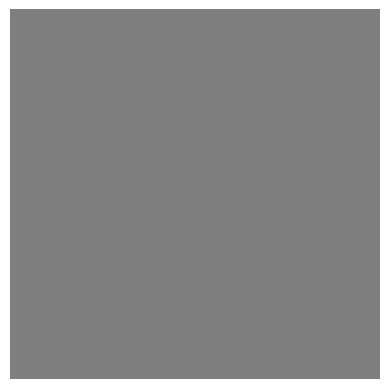

In [26]:
transforms = weights.transforms()
width, height = 256, 256
image = transforms(0.5*torch.ones(3, height, width)).requires_grad_()  # do .cuda() if connected to gpu

def inverse_transforms(tensor):  # inverts the transforms(...) colour mapping, not the resizing/cropping
    mean = torch.tensor(transforms.mean, device=tensor.device).view(3, 1, 1)
    std = torch.tensor(transforms.std, device=tensor.device).view(3, 1, 1)
    return tensor * std + mean

def draw(tensor, ax=None):
    if not ax:
        fig, ax = plt.subplots()
        ax.set_axis_off()
    ax.imshow(inverse_transforms(tensor).permute(1, 2, 0).detach().cpu().numpy())

draw(image)

In [27]:
def predict(image):  # takes only one image_tensor (hence all the squeezing/unsqueezing)
    return resnet(image.unsqueeze(0)).detach().squeeze(0).softmax(0)


activation = None
channel = 1  # chosen arbitrarily
def hook(_model, _input, output):
    c = output[0, channel]  # indexing by 0 cos we're doing batch size 1
    global activation; activation = c[c.shape[0]//2, c.shape[1]//2]  # centre of the channel
    
hook_handle = resnet.layer2.register_forward_hook(hook)

In [28]:
optimizer = torch.optim.Adam([image], lr=0.5)
num_iterations = 1000


for i in range(num_iterations):
    optimizer.zero_grad()
    predict(image)  # the "prediction" isn't relevant, but the relevant activation will be stored
    
    loss = -activation
    loss.backward()
    optimizer.step()
    if i%100 == 0:
        print(f"Iteration {i}: Loss = {loss.item()}")

    #with torch.no_grad():
    #    unprocessed.clamp_(0, 1)
    

hook_handle.remove()

Iteration 0: Loss = -0.16266663372516632
Iteration 100: Loss = -141.37435913085938
Iteration 200: Loss = -352.0659484863281
Iteration 300: Loss = -580.8522338867188
Iteration 400: Loss = -817.40478515625
Iteration 500: Loss = -1057.88623046875
Iteration 600: Loss = -1300.926025390625
Iteration 700: Loss = -1546.514892578125
Iteration 800: Loss = -1794.017333984375
Iteration 900: Loss = -2043.41552734375


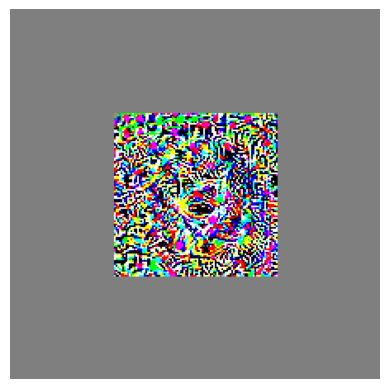

In [25]:
draw(image)

#### D.2. Regularised Feature Visaulisation

The previous method has likely produced rather grainy results, often with periodic artifcacts, as explained in 'The Enemy of Feature Visualization' section of [the article](https://distill.pub/2017/feature-visualization/#optimization). To obtain more natural looking, and thus more interpretable results, it helps if we add some regularization. A simple regularisation technique is to apply Gaussian blur, small rotations or magnification
to your image between gradient steps. This is demonstrated in the post. Repeat the first task but now with this added regularisation approach.

*Note:* The feature visualization reference contains very interpretable, and beautiful results. Getting these pretty images is often a result of extensive tweaking of the methods on the basis of subjective criteria, and the authors of this writeup really knew what they were doing. Don't worry if your results are not as pretty as those. What we are looking for is demonstrating an understanding of how to optimize different parts of the image, and using the regularization techniques successfully.

## Section D Writeup checklist

Please compile your findings into a writeup, with the main non-appendix content fitting into **a single page**.

Please make sure you include:
* 1 figure (3 subfigures) showing your unregularised results from D.1
* at least one figure (multiple subfigures) showing your most successful regularised results from D.2
* description of the regularisation techniques explored
* description of which techniques worked best for you
* appendix with stripped-down code snippet of the main loop you used (please remove any boilerplate, import statements, plotting and logging, focussing on the algorithm. Your code may include short comments if you find it improves readability)
* optional appendix with additional figures

# E: Transformer vs MLP Mixer on Modular Arithmetic

_[20 marks] 2 page writeup + appendices_

In this part of the assignment, you will train models to perform modular addition of integers A bit more formally, the model has to learn to predict elements of the Cayley table (multiplication table) of the *97-element cyclic group*.

If we represent integers as integers, the problem becomes very easy, as models built on linear algebra operations already "know" how to add numbers. Instead, we will pretend we don't know that the group is isomorphic to integers, and we will encode the 97 elements of the group as arbitrarily chosen tokens. This way, the model will have to build a useful representation of group elements.

Mathematically, we consider the following dataset:

* token alphabet $\Sigma$ of size $97$
* a bijective map $\pi: \Sigma \mapsto \mathbb{Z}_{97}$, where $\mathbb{Z}_{97} = \{0, 1, \ldots, 96\}$
* a dataset consisting of pairs of inputs $x = [x_1, x_2] \in \Sigma^2$ and labels $y \in \Sigma$ such that:

$$
\pi(x_1) + \pi(x_2) \equiv \pi (y)\ \ (\operatorname{mod} 97)
$$

For simplicity, we can choose the alphabet $\Sigma$ to be $\mathbb{Z}_{97}$ in which case $\pi$ becomes a permutation.

Note that there are $97\times 97 = 9409$ unique possible datapoints, forming the Cayley table (multiplication table) for the 97-element cyclic group.

Your models will have to learn to predict $y$ from $x$, given only a fraction of all pairs as training data. For example:

![](https://i.imgur.com/SfwC4Jy.png)

The figure depicts the Cayley table for the 5-element cyclic group over a chosen alphabet $\Sigma = {a,b,c,d,e}$. There are 25 entries, corresponding to 25 possible datapoints. We will sample 18 of these as training data, while 7 (shown in grey) are held out as test data. We fit our model to the entries in the training data (for example the pair $x = [a, b], y = b$) and evaluate the model's accuracy in predicting the held-out entries.


## E.1: Creating a dataset

Implement a dataset for the task above:
* make it a subclass of the pytorch `TensorDataset`. This will make it easy to move the entire dataset to the GPU.
* the dataset should implement an invertible mapping $\pi$ from a token alphabet $\sigma$ to integers $\mathbb{Z}_{97}$ - consider using `random.shuffle` with a fixed random seed.
* the dataset should contain all entries of the multiplication table exactly once.
* test your implementation with assertions about the total number of datapoints, the total number of each token appearing in different positions in the dataset, etc.

## E.2: Implement a Transformer

Now, let's build a small, shallow transformer, using components from the pytorch neural network libraries.

First, take some time thinking about model requirements:
1. Decide whether you want a decoder-only, encoder-only or encoder-decoder transformer for this task.
1. Decide whether you need position embeddings.
1. Remember that autoregressive transformer language models use causal attention masks. Does your model need this, if so, where?
1. Since the label you predict is discrete, you have to choose the loss function that reflects this.


Then implement a model. You may use pre-existing layers or building blocks, for example [TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html). Please don't simply import or copy a complete model used someplace else. Nor do you have to implement attention from ground up. Finally, your implemented Transformer model on a set percentage of the modular addition data.


Hints:
* A decoder-only transfomer is composed of token and position embeddings as the first operation, these are followed by causal transformer layer.
* By causal masking I referred to the Masked Self-Attention layer (with a triangular mask so each token only aggregates information from the past but not the future). Pytorch provides masking functionality via an argument to the `forward` method.
* The original Transformer used layer normalization after the other operations, later it's been observed that it's better to normalize before the operations. Torch provides a flag to make this change.
* Don't forget the token embedding layer as the first operation of the transformer.
* This problem was chosen because a relatively small Transformer model can be trained successfully. You should see that using $50-70\%$ of the dataset as training should yield very good test accuracy.
* This task was inspired by the [paper on grokking](https://arxiv.org/abs/2201.02177), whose results suggest that a small transformer, trained with AdamW and weight decay would perform well, and these results are widely reproduced.

## E.3: Implement an MLP Mixer

Here, we will implement the simple, and somewhat quirky model Neil Houlsby presented in his guest lecture: the [MLP Mixer](https://arxiv.org/abs/2105.01601). Although it might look complicated, it is easier to code from scratch than a Transformer as it uses standard layers.

The MLP mixer was inspired by encoder-only transformers, which have alternating blocks of multi-head self-attention and fully conected networks (MLPs). The attention layer communicates information across tokens, while the fully connected network processes each token in isolation, in parallel.

### MLPs are All you Need

Below is a drawing of the MLP-mixer architecture. (the figure labels tokens as "patches" and embedding dimensions as "channels", owing to the fact that this architecture was introduced in a vision context)

![](https://mchromiak.github.io/articles/2021/May/05/MLP-Mixer/img/Mixer.png)

The MLP mixer model replaces multi-head attention with an MLP. As a starting point, like in a transformer, an embedding layer maps our input to a tensor of size `batchsize * sequence_length * embedding_dim`.

Then, it alternates two kinds of blocks:
* odd blocks apply an MLP across tokens, with input and output dimension `sequence_length` evaluated in parallel for every input in the batch and every embedding dimension.
* even blocks apply a MLP across embedding dimensions, with input and output dimension `embedding_dim`, evaluated in parallel for every datapoint in a batch and every input token.

Please implement your MLP Mixer architecture from scratch (i.e. using basic pytorch layers such as `Linear`, `ReLU`, `LayerNorm`, but please don't use a pre-defined MLP Mixer).

Notes:
* as you see, in the original architecture includes `LayerNorm` which speeds up training, as well as skip connections like in a ResNet which are especially important in deep versions.
* the pytorch [`Linear` layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is implemented in such a way that it always applies matrix multiplication to the last dimension of a tensor, and the operation is carried out in parallel for all other dimensions. This will come very handy here.
* The MLP mixer only works on a fixed size input sequence. Thus, it is nice for image processing, and it applies to our situation where the input is always two tokens long.
* Like Neil Suggested, to make these architectures work in the low data regime, regularisation is likely helpful. Weight decay combined with AdamW could be a good starting point.

## E.4: Evaluate data-efficiency of the models

Once you have a working version of one or both of the models above, evaluate generalisation performance for varying fractions of training data used (using as low as, say, 10%, all the way to using almost all).

**Important:** Please use `random_split` utility to split the available data, into training and test, or perhaps training, validation and test. For consistency across students, please make sure that your test data and training data do not overlap!

Hints:
* past results suggest that for a Transformer, AdamW and weight decay performs well, and it is possible to get non-trivial performance out of this model using less than half the data for training.
* perform some hyperparameter search for a fair evaluation - though it is understood you have limited time, so you may not find optimal parameters, that's OK.
* it is good practice to repeat the experiments using multiple random seeds (for model initialisation and training data split) but given the time constraints, it is not expected
* if you struggle with the Transformer, and/or MLP Mixer models, you may implement a different model that you're more comfortable with.

## Section E Writeup checklist

Please compile your findings into a writeup of **two pages** plus appendices, including the following:
* figure(s) showing Transformer and MLP Mixer performance (y axis) as a function of the fraction of data used for training (x axis)
* description of the models used (encoder-only, decoder only, etc; whether you used masking in self-attention; how many layers, etc)
* description of hyperparameters, optimizers, regularisation techniques, and your method of selecting/optimizing these
* interpretation/discussion of results, any difficulties
* comparison of the merits/drawbacks of the models, both based on your findings, and in general
* appendix: stripped-down code for the dataset implementation (please remove any non-essential parts)
* appendix: stripped-down code for the transformer implementation
* appendix: stripped-down code for MLP-Mixer implementation

# F: Mini-Project

_[40 marks] 4-page writeup plus appendices_

Please **choose one** of the proposed mini-project options below. Add as many text and code cells under the heading as you'd like. You may attempt more than one, but we will only mark one: please write below which mini-project you'd like to get marked on:

**I would like my solution for mini-project __________ to be marked.**

## F.1: Compositional Generalisation in Group Structured Data

The starting point for this exercise is Section E, where you trained models to predict missing entries of the Cayley table for $\mathbb{Z}_{97}$ given only a random subset of entries. If your models worked well there, and you like groups, this mini-project might appeal to you.

There is a lot of interesting compositional structure in groups. The 97-element cyclic group is rather boring, it is a simple group, meaning its only subgroups are the trivial group $\{e\}$ and itself. This is because $97$ is a prime number. Cyclic groups with non-prime size $n$, on the other hand, have more intereseting subgroup structure: For every divisor $d$ of $n$, there is exactly one subgroup of order (size) $d$. Symmetric groups (groups over permutations) have even more interesting subgroup structure. For example, $S_4$ contains 24 elements, and several subgoups of sizes corresponding to every divisor of 24. See details [on Wikipedia](https://en.wikipedia.org/wiki/Subgroup#Example:_Subgroups_of_S4). Elementary Albelian groups $\mathbb{Z}_p^k$ are another example of groups with rich subgroup structure.

In this mini-project, your task is to collect evidence relating to the following hypothesis:

_Hypothesis:_ Transformers (and/or other models) are able to learn the full Cayley table of rich groups like $S_n$ or $\mathbb{Z}_p^k$ seeing data only from certain sets of subgroups (i.e. specific slices of the Cayley table).

We know that small transformers are able to learn the Cayley table of $S_5$ when a small (less than 50%) fraction of randomly selected entries is provided as training data. To test the hypothesis above, you would design a different training-test split strategy which selects the union of certain subgroups as training data, with the remaining entries as test data. Is sampling subgroups better or worse than random sampling?

High marks for a complete investigation, including commentary about what your findings might reveal about compositional and statistical generalisation in Transformers and/or other models. It is expected that you put more effort into tuning your hyperparameters and improving your models than what is expected for part E alone.

## F.2 Needle in a Haystack

Modern language models can handle increasingly long context length (longest prefix sequence the model can ingest and probability distribution of the next token). How do we know the model can efficiently handle such a long context?
In the [Needle In A Haystack (NIAH) ](https://github.com/gkamradt/LLMTest_NeedleInAHaystack) evaluation a small piece of text containing a specific fact or secret is placed within a long block of text, and the model is prompted to retrieve this fact. A good model should perform accurately irrespective of how long this block of thext is, and where the fact is embedded in it.

In this more **engineering-focussed** mini-project you will study models using a toy problem that follows the needle-in-a-haystack paradigm, and evaluate various small neural networks on how well they perform at this task.

### Questions you can explore:

You should not do all of these (you will notice they add up to more than 40 marks), these are just given as indication of the number of marks awarded for certain amount of work. You should 'build your own miniproject'.

* Create toy dataset(s) where in each example some information (needle) is embedded inside a longer random string (haystack) in some non-ambiguous way, and the goal is to retrieve the needle from the haystack. The task should not be too trivial or too difficult, and it's fine to use a simple setting such as binary strings or PCFGs. It is up to you to specify the problem further. *(max ~5 marks)*
* Train a model and evaluate its performance as a function of haystack size and needle location within the haystack, generating a plot similar to NIAH evaluation. Investigate length extrapolation: How well does the trained model do when evaluated on longer contexts than it has seen during training. *(max ~5 marks)*
* Train and compare multiple different architectures (RNNs, 1D ConvNets). Illustrate
and discuss srengths and weaknesses of each for this kind of task *(max ~10 marks)*
* Use RASP to implement the needle retrieval task, demonstrate that your code works. *(max ~10 marks)*
* Hardwire a solution into a neural network that solves the needle-in-a-haystack retrieval task *(max ~10 marks)*
* Implement [efficient transformer](https://arxiv.org/abs/2009.06732) layer(s) of your choice that allow for higher context windows, and demonstrate their performance on your NIAH toy task. *(~20 marks for a very thorough treatment)*
* Implement an adversarial attack showing that embedding certain distractors in the haystack can hurt (or help) retrieval of the needle. *(~15 marks for a thorough treatment)*

## F.3: The Natural Next Step

In Assignment 1, you explored the importance of parametrizations of DNNs. Different parametrizations can behave differently under gradient descent and may lead to qualitatively different solutions. In this mini-project, you will look at how we can further understand, mitigate or remove the influence of parametrization.

This mini-project option is **more theory-focussed**, and asks you to experiment with Natural Gradient Descent (NGD) and related methods. We provide you with [some notes on NGD](https://hackmd.io/@fhuszar/H1-t95X3T) and some resources linked from there that explain how it is derived.

### Questions to Explore

You should not do all of these (you will notice they add up to more than 40 marks), these are just given as indication of the number of marks awarded for certain amount of work. You should 'build your own miniproject'.

* Explore Adaptive Learning Rates *(~10 marks)*
  * In Question A.5 of Assignment 1, you explored how using different optimizers affects training from equivalent initialisations. If you used Adam, you should have observed a smaller difference effect than when using SGD. *Discuss/illustrate mathematically why this happens. Can you design and implement a new optimiser based on your observations that is uneffected by the reparametrisation in A.5.2? Can you connect this to NGD?
*  Implement NGD for the toy problem in A.5 *(~30 marks for thorough solution)*
  * Follow the outline of the algorithm given in the notes, implement NGD. Use your algorithm on the toy task from Question A.5 and show that NGD displays invariance to reparametrisation. A couple notes:
    * There are multiple ways to compute the Fisher information matrix or the natural gradient. Your implementation does **not** need to be super efficient, but if you choose a very inefficient version, perhaps comment on how it could be made more efficient, or what the main bottlenecks are.
    * It's fine if you implement NGD specifically for this shallow MLP architecture, and if it does not work generally for arbitrary architectures. That said, we do encourage you to think about using generic automatic differentiation tools.
* Try an [open source implementation](https://github.com/n-gao/pytorch-kfac) of an optimizer like K-FAC. Reason about whether K-FAC is invariant to this specific kind of reparametrization in this specific architecture. *(~15 marks for a thorough exploration)*
* Prove the invariance of Natural Gradient Flow under smooth, differentiable reparametrisations *(~10 marks)*
* Discuss or illustrate the merits of using Fisher information averaged over test vs training data. *(max ~10 marks)*